[![image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phillipslucas/TheBeans/blob/main/docs/examples/pysheds.ipynb)

In [1]:
import numpy as np
import pandas as pd
from pysheds.grid import Grid
import geopandas as gpd
from shapely import geometry, ops
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import rasterio

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
sns.set_palette('husl')


# 1m nodata blank
# 10m nodata blank
# 30m nodata -999999

In [2]:
grid = Grid.from_raster(r"C:\Users\phill\Desktop\GEOG424\rasters\USGS_30m.tif", data_name='dem', no_data = -999999)
dem = grid.read_raster(r"C:\Users\phill\Desktop\GEOG424\rasters\USGS_30m.tif")
#data type dictates nodata value, if no assigned no data value no data is 0, assign nodata value or get errors

#check dtype
dem.dtype

dtype('float32')

Text(0, 0.5, 'Latitude')

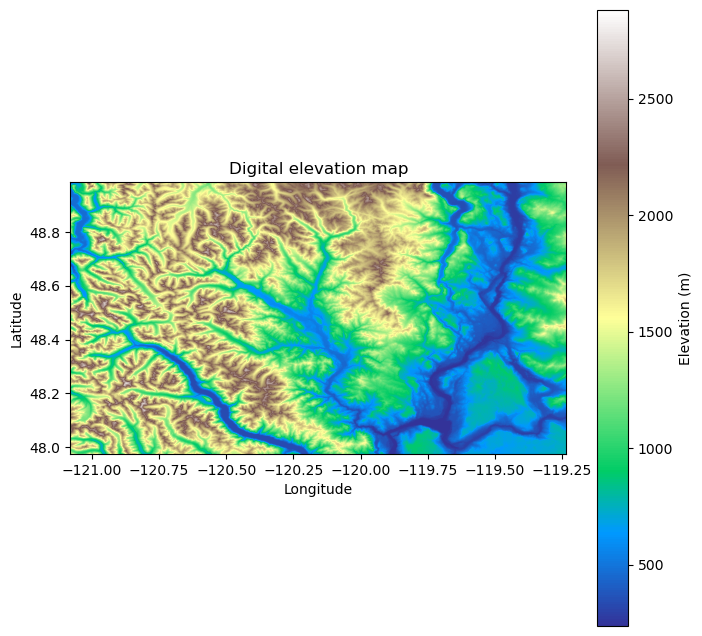

In [3]:
fig, ax = plt.subplots(figsize=(8,8))
plt.imshow(grid.view(dem), extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.title('Digital elevation map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [4]:
#Surface conditioning, fills pits, fills depressions, resolves flats (pit, flood, inflate)

#not empty, just sparse
pits_detect = grid.detect_pits(dem)


#fill fits, check for pits, error if pits
fillpit = grid.fill_pits(dem)
pits_detect = grid.detect_pits(fillpit)
assert not pits_detect.any()


#dep_detect shows depressions in areas expected
filldepp = grid.fill_depressions(fillpit)
dep_detect = grid.detect_depressions(filldepp)
assert not dep_detect.any()

#Fill flats. Assert throwing error, likely flats in data
noflats = grid.resolve_flats(filldepp, eps=1e-12, max_iter=1e9) #eps and max_iter too small for large flats
flats_detect = grid.detect_flats(noflats)
# assert not flats_detect.any()




Text(0.5, 1.0, 'Depressions')

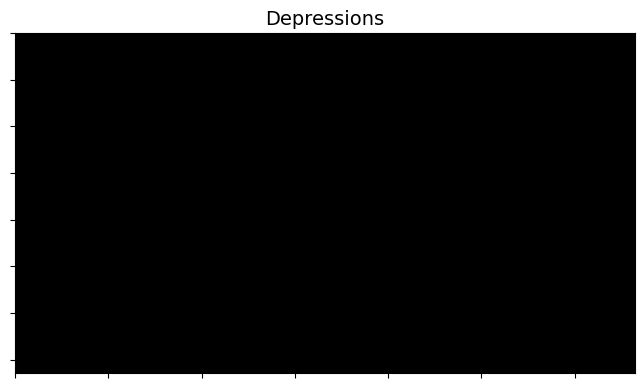

In [18]:
# fig, ax = plt.subplots(figsize=(8,8))
# ax.imshow(dep_detect, cmap='cubehelix', zorder=1)
# ax.set_yticklabels([])
# ax.set_xticklabels([])
# plt.title('Depressions', size=14)

In [6]:
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

#flow direction D8
fdir = grid.flowdir(noflats, dirmap=dirmap)

#flow accumulation
acc = grid.accumulation(fdir)



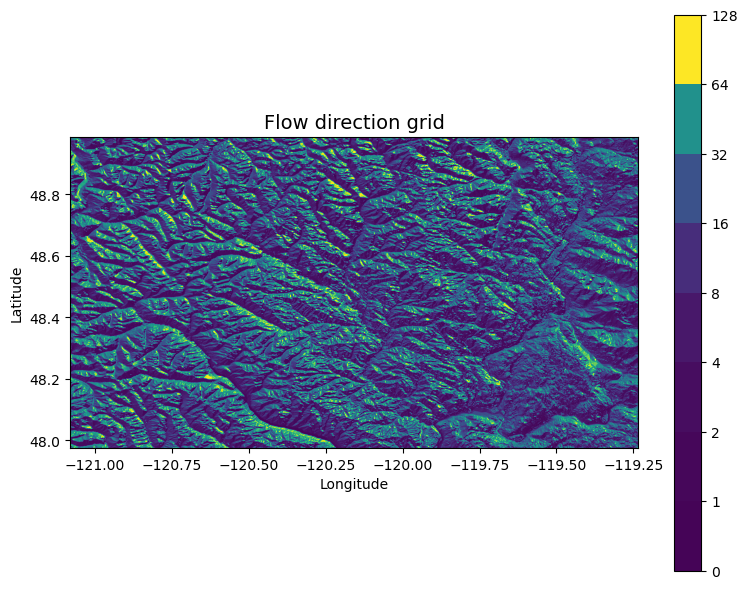

In [8]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

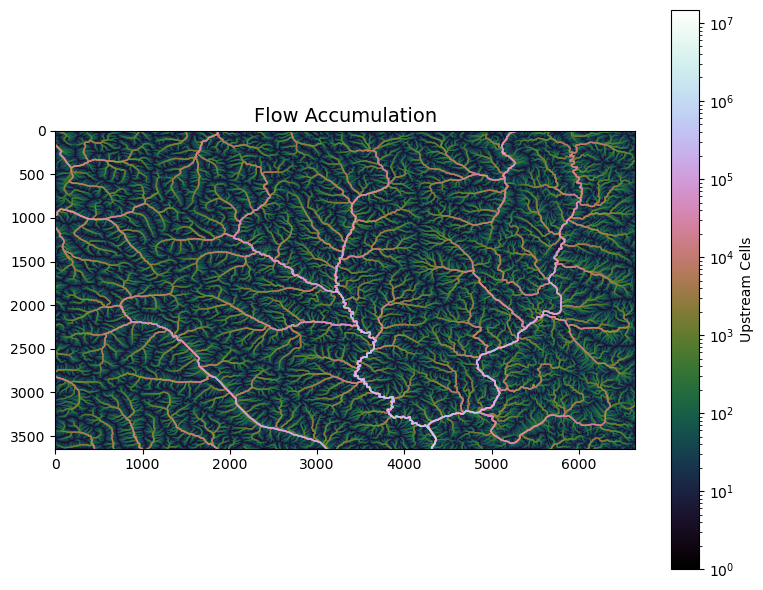

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
im = ax.imshow(acc, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.tight_layout()

In [15]:
#pour point
x, y = -119.912764, 48.049753

# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 10000, (x, y))

catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap)

In [16]:
catch_view = grid.view(catch)

Text(0.5, 1.0, 'Delineated Catchment')

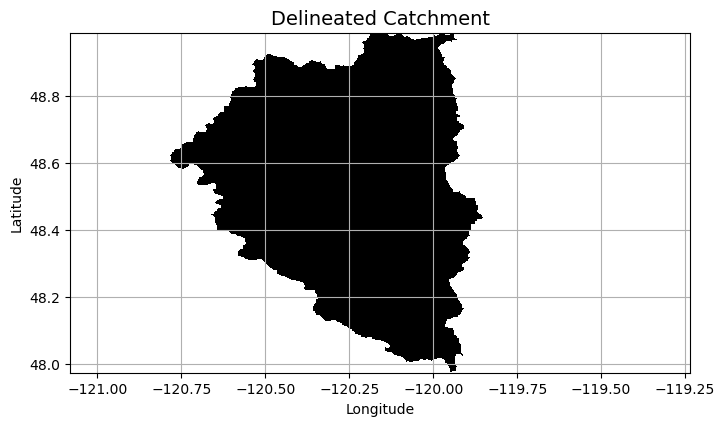

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(np.where(catch_view, catch_view, np.nan), extent=grid.extent,
               zorder=1, cmap='Greys_r')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment', size=14)
